In [1]:
from brian2 import *
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

%matplotlib inline
seed(12345)

In [2]:
start_scope()

################################################################################
# Model parameters
################################################################################
### General parameters
duration = 0.5*second  # Total simulation time
sim_dt = 0.1*ms        # Integrator/sampling step

N_sst = 2 # Number of SST neurons (inhibitory)
N_pv = 2  # Number of PV neurons (inhibitory)
N_cc = 2  # Number of CC neurons (excitatory)
N_cs = 2  # Number of CS neurons (excitatory)

### Neuron parameters
tau_S   = 16*ms  # 
tau_D   =  7*ms  #
tau_SST = 20*ms  #
tau_PV  = 10*ms  #
tau_E   =  5*ms  # Excitatory synaptic time constant
tau_I   = 10*ms  # Inhibitory synaptic time constant

C_S   = 370*pF
C_D   = 170*pF
C_SST = 100*pF
C_PV  = 100*pF

E_l  = -70*mV   # leak reversal potential
E_e  =   0*mV   # Excitatory synaptic reversal potential
E_i  = -80*mV   # Inhibitory synaptic reversal potential

V_t  = -50*mV   # spiking threashold
V_r  = E_l      # reset potential

c_d = 2600 * pA  # back-propagates somatic spikes to to the dendrites
g_s = 1300 * pA  # propagates dendritic regenerative activity to soma
g_d = 1200 * pA  # propagates dendritic regenerative activity to denderites



### Synapse parameters
w_e = 0.05*nS  # Excitatory synaptic conductance
w_i = 1.0*nS   # Inhibitory synaptic conductance


### External Input
g = 500*pA
M = 1.05 
I_ext_sst = [0*pA for i in range(N_sst)]
I_ext_pv = [0*pA for i in range(N_pv)]
I_ext_cs = I_ext_cc = [g, g*M]

################################################################################

In [3]:
### Sigmoid function params
E_d = -38*mV  # position control of threshold
D_d =   6*mV  # sharpness control of threshold 

# TODO see how to reference this from equation 
@check_units(x=volt, result=1)
def sigmoid(x):
    return 1/(1+np.exp(-(-x-E_d)/D_d))

In [4]:
eqs_sst_inh = '''
    dv/dt = ((E_l-v)/tau_SST + I/C_SST) : volt (unless refractory)

    dg_e/dt = -g_e/tau_E : siemens
    dg_i/dt = -g_i/tau_I : siemens

    I = I_external + I_syn : amp
    I_syn = g_e*(E_e - v) + g_i*(E_i - v) : amp
    I_external : amp
'''

eqs_pv_inh = '''
    dv/dt = ((E_l-v)/tau_PV + I/C_PV) : volt (unless refractory)

    dg_e/dt = -g_e/tau_E : siemens
    dg_i/dt = -g_i/tau_I : siemens

    I = I_external + I_syn : amp
    I_syn = g_e*(E_e - v) + g_i*(E_i - v) : amp
    I_external : amp
'''

eqs_exc = '''
    dv_s/dt = ((E_l-v_s)/tau_S + (g_s*(1/(1+exp(-(v_d-E_d)/D_d))) + I_s)/C_S) : volt (unless refractory)

    dg_es/dt = -g_es/tau_E : siemens
    dg_is/dt = -g_is/tau_I : siemens

    I_s = I_external + I_syn_s : amp
    I_syn_s = g_es*(E_e - v_s) + g_is*(E_i - v_s) : amp
    I_external : amp

    dv_d/dt = ((E_l-v_d)/tau_D + (g_d*(1/(1+exp(-(v_d-E_d)/D_d))) + c_d*K + I_d)/C_D) : volt

    dg_ed/dt = -g_ed/tau_E : siemens
    dg_id/dt = -g_id/tau_I : siemens

    I_d = I_syn_d : amp
    I_syn_d = g_ed*(E_e - v_d) + g_id*(E_i - v_d) : amp
    K : 1
'''

In [5]:
# SST Neurons
sst_neurons = NeuronGroup(N_sst, model=eqs_sst_inh, threshold='v > V_t',
                              reset='v = E_l', refractory=8.3 * ms, method='euler')
sst_neurons.set_states({'I_external': I_ext_sst})
sst_neurons.v = 'E_l + rand()*(V_t-E_l)'
sst_neurons.g_e = 'rand()*w_e'
sst_neurons.g_i = 'rand()*w_i'

# PV Neurons
pv_neurons = NeuronGroup(N_pv, model=eqs_pv_inh, threshold='v > V_t',
                             reset='v = E_l', refractory=8.3 * ms, method='euler')
pv_neurons.set_states({'I_external': I_ext_pv})
pv_neurons.v = 'E_l + rand()*(V_t-E_l)'
pv_neurons.g_e = 'rand()*w_e'
pv_neurons.g_i = 'rand()*w_i'

# CS Neurons
cs_neurons = NeuronGroup(N_cs, model=eqs_exc, threshold='v_s > V_t',
                             reset='v_s = E_l', refractory=8.3 * ms, method='euler')
cs_neurons.set_states({'I_external': I_ext_cs})
cs_neurons.v_s = 'E_l + rand()*(V_t-E_l)'
cs_neurons.v_d = -70 * mV
cs_neurons.g_es = cs_neurons.g_ed = 'rand()*w_e'
cs_neurons.g_is = cs_neurons.g_id = 'rand()*w_i'

# CC Neurons
cc_neurons = NeuronGroup(N_cc, model=eqs_exc, threshold='v_s > V_t',
                             reset='v_s = E_l', refractory=8.3 * ms, method='euler')
cc_neurons.set_states({'I_external': I_ext_cc})
cc_neurons.v_s = 'E_l + rand()*(V_t-E_l)'
cc_neurons.v_d = -70 * mV
cc_neurons.g_es = cc_neurons.g_ed = 'rand()*w_e'
cc_neurons.g_is = cc_neurons.g_id = 'rand()*w_i'

In [6]:
# CS_CS 0, CS_SST 1, CS_PV 2, SST_CS 3, PV_CS 4, CC_CC 5, CC_SST 6, CC_PV 7, SST_CC 8, PV_CC 9, CC_CS 10, SST_PV 11, SST_SST 12, PV_PV 13, PV_SST 14, 
# conn_probs = [0.16, 0.23, 0.18, 0.52, 0.43, 0.06, 0.26, 0.22, 0.13, 0.38, 0.09, 0.29, 0.1, 0.5, 0.14]
conn_probs = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

# SST <=> PV
conn_SST_PV = Synapses(sst_neurons, pv_neurons, on_pre='g_i+=w_i', name='SST_PV') # inhibitory
conn_SST_PV.connect(p=conn_probs[11])
conn_PV_SST = Synapses(pv_neurons, sst_neurons, on_pre='g_i+=w_i', name='PV_SST') # inhibitory
conn_PV_SST.connect(p=conn_probs[14])

# PV <=> PYR soma
## target CS soma
conn_PV_CSsoma = Synapses(pv_neurons, cs_neurons, on_pre='g_is+=w_i', name='PV_CSsoma') # inhibitory
conn_PV_CSsoma.connect(p=conn_probs[4])
conn_CSsoma_PV = Synapses(cs_neurons, pv_neurons, on_pre='g_e+=w_e', name='CSsoma_PV') # excitatory
conn_CSsoma_PV.connect(p=conn_probs[2])

## target CC soma
conn_PV_CCsoma = Synapses(pv_neurons, cc_neurons, on_pre='g_is+=w_i', name='PV_CCsoma') # inhibitory 
conn_PV_CCsoma.connect(p=conn_probs[9])
conn_CCsoma_PV = Synapses(cc_neurons, pv_neurons, on_pre='g_e+=w_e', name='CCsoma_PV') # excitatory
conn_CCsoma_PV.connect(p=conn_probs[7])

# SST <=> PYR soma
## target CS soma
conn_SST_CSsoma = Synapses(sst_neurons, cs_neurons, on_pre='g_is+=w_i', name='SST_CSsoma') # inhibitory (optional connection)
conn_SST_CSsoma.connect(p=conn_probs[3])
conn_CSsoma_SST = Synapses(cs_neurons, sst_neurons, on_pre='g_e+=w_e', name='CSsoma_SST') # excitatory
conn_CSsoma_SST.connect(p=conn_probs[1])

## taget CC soma
conn_SST_CCsoma = Synapses(sst_neurons, cc_neurons, on_pre='g_is+=w_i', name='SST_CCsoma') # inhibitory (optional connection)
conn_SST_CCsoma.connect(p=conn_probs[8])
conn_CCsoma_SST = Synapses(cc_neurons, sst_neurons, on_pre='g_e+=w_e', name='CCsoma_SST') # excitatory
conn_CCsoma_SST.connect(p=conn_probs[6])

# CC => CS 
## target CS soma
conn_SST_CCdendrite = Synapses(cc_neurons, cs_neurons, on_pre='g_es+=w_e', name='CC_CSsoma') # excitatory
conn_SST_CCdendrite.connect(p=conn_probs[10])

# self connections
conn_CSsoma_CSsoma = Synapses(cs_neurons, cs_neurons, on_pre='g_es+=w_e', name='CSsoma_CSsoma')  # excitatory
conn_CSsoma_CSsoma.connect(p=conn_probs[0])
backprop_CS = Synapses(cs_neurons, cs_neurons, on_pre={'up': 'K += 1', 'down': 'K -=1'},
                           delay={'up': 0.5 * ms, 'down': 2 * ms}, name='backprop_CS')
backprop_CS.connect(condition='i==j')  # Connect all CS neurons to themselves

conn_CCsoma_CCsoma = Synapses(cc_neurons, cc_neurons, on_pre='g_es+=w_e', name='CCsoma_CCsoma')  # excitatory
conn_CCsoma_CCsoma.connect(p=conn_probs[5])
backprop_CC = Synapses(cc_neurons, cc_neurons, on_pre={'up': 'K += 1', 'down': 'K -=1'},
                           delay={'up': 0.5 * ms, 'down': 2 * ms}, name='backprop_CC')
backprop_CC.connect(condition='i==j')  # Connect all CC neurons to themselves

conn_SST_SST = Synapses(sst_neurons, sst_neurons, on_pre='g_i+=w_i', name='SST_SST')  # inhibitory
conn_SST_SST.connect(p=conn_probs[12])

conn_PV_PV = Synapses(pv_neurons, pv_neurons, on_pre='g_i+=w_i', name='PV_PV')  # inhibitory
conn_PV_PV.connect(p=conn_probs[13])


# SST => PYR dendrite
## target CS dendrite
conn_SST_CSdendrite = Synapses(sst_neurons, cs_neurons, on_pre='g_id+=w_i', name='SST_CSdendrite') # inhibitory
conn_SST_CSdendrite.connect(p=conn_probs[3]) # not sure about this here

## target CC dendrite
conn_SST_CCdendrite = Synapses(sst_neurons, cc_neurons, on_pre='g_id+=w_i', name='SST_CCdendrite') # inhibitory
conn_SST_CCdendrite.connect(p=conn_probs[8]) # not sure about this here



WARNING    Removing unsupported flag '-march=native' from compiler flags. [brian2.codegen.cpp_prefs]


In [7]:
# ##############################################################################
# # Monitors
# ##############################################################################

# Record spikes of different neuron groups
spike_mon_sst = SpikeMonitor(sst_neurons)
spike_mon_pv = SpikeMonitor(pv_neurons)
spike_mon_cs = SpikeMonitor(cs_neurons)
spike_mon_cc = SpikeMonitor(cc_neurons)

# Record conductances and membrane potential of neuron ni
state_mon_sst = StateMonitor(sst_neurons, ['v', 'g_e', 'g_i'], record=[0])
state_mon_pv = StateMonitor(pv_neurons, ['v', 'g_e', 'g_i'], record=[0])
state_mon_cs = StateMonitor(cs_neurons, ['v_s', 'v_d', 'g_es', 'g_is', 'g_ed', 'g_id'], record=[0])
state_mon_cc = StateMonitor(cc_neurons, ['v_s', 'v_d', 'g_es', 'g_is', 'g_ed', 'g_id'], record=[0])

In [8]:
# ##############################################################################
# # Simulation run
# ##############################################################################

defaultclock.dt = sim_dt

run(duration, report='text')

Starting simulation at t=0. s for a duration of 0.5 s
0.5 s (100%) simulated in < 1s


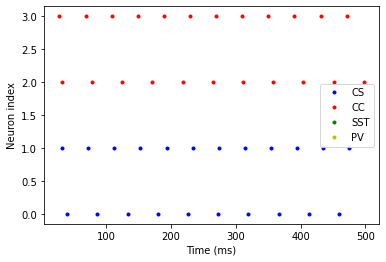

In [9]:
################################################################################
# Analysis and plotting
################################################################################

# Raster plot
plot(spike_mon_cs.t / ms, 0 + spike_mon_cs.i, '.b', label='CS')
plot(spike_mon_cc.t / ms, N_cs + spike_mon_cc.i, '.r', label='CC')
plot(spike_mon_sst.t / ms, (N_cs + N_cc) + spike_mon_sst.i, '.g', label='SST')
plot(spike_mon_pv.t / ms, (N_cs + N_cc + N_sst) + spike_mon_pv.i, '.y', label='PV')
xlabel('Time (ms)')
ylabel('Neuron index');
legend(loc='best')

Spike times CS: [ 31.6  39.5  72.   86.1 112.3 132.8 152.6 179.5 192.9 226.2 233.2 272.9
 273.6 314.  319.5 354.4 366.1 394.7 412.7 435.  459.4 475.3] ms


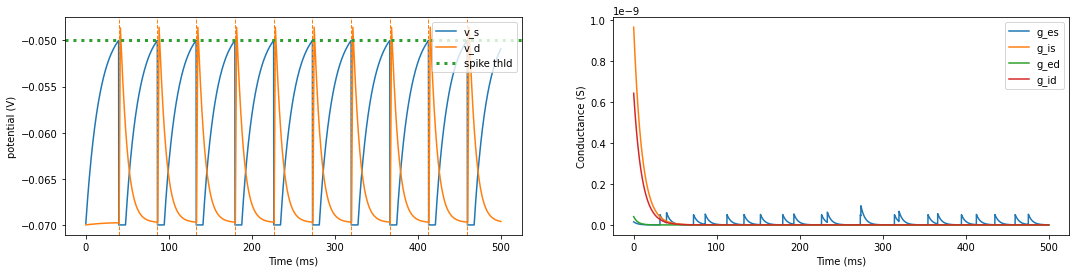

In [10]:
# CS Neurons plot

figure(figsize=(18, 4))
subplot(1, 2, 1)
plot(state_mon_cs.t / ms, state_mon_cs.v_s[0], label='v_s')
plot(state_mon_cs.t / ms, state_mon_cs.v_d[0], label='v_d')
for (t, i) in zip(spike_mon_cs.t, spike_mon_cs.i):
    if i == 0:
        axvline(t / ms, ls='--', c='C1', lw=1)
axhline(V_t / mV / 1000, ls=':', c='C2', lw=3, label='spike thld')
xlabel('Time (ms)')
ylabel('potential (V)')
legend(loc='upper right')

subplot(1, 2, 2)
plot(state_mon_cs.t / ms, state_mon_cs.g_es[0], label='g_es')
plot(state_mon_cs.t / ms, state_mon_cs.g_is[0], label='g_is')
plot(state_mon_cs.t / ms, state_mon_cs.g_ed[0], label='g_ed')
plot(state_mon_cs.t / ms, state_mon_cs.g_id[0], label='g_id')

xlabel('Time (ms)')
ylabel('Conductance (S)')
legend(loc='best')

print("Spike times CS: %s" % spike_mon_cs.t[:])

Spike times CC: [ 27.4  31.1  67.8  77.7 108.2 124.3 148.5 171.  188.8 217.7 229.1 264.4
 269.4 309.8 311.1 350.2 357.7 390.6 404.3 430.9 451.  471.2 497.7] ms


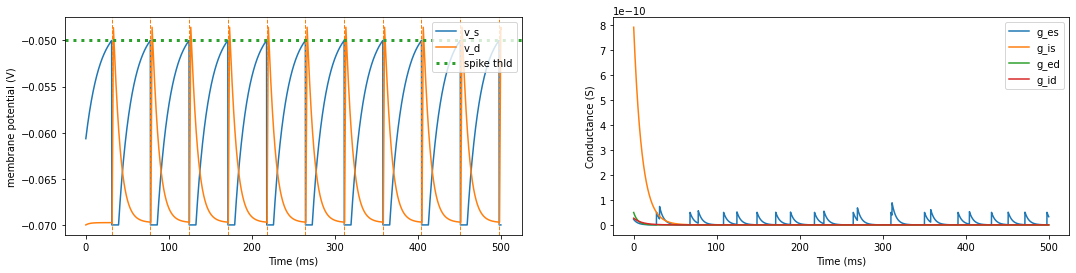

In [11]:
# CC Neurons

figure(figsize=(18, 4))
subplot(1, 2, 1)
plot(state_mon_cc.t / ms, state_mon_cc.v_s[0], label='v_s')
plot(state_mon_cc.t / ms, state_mon_cc.v_d[0], label='v_d')
for (t, i) in zip(spike_mon_cc.t, spike_mon_cc.i):
    if i == 0:
        axvline(t / ms, ls='--', c='C1', lw=1)
axhline(V_t / mV / 1000, ls=':', c='C2', lw=3, label='spike thld')
xlabel('Time (ms)')
ylabel('membrane potential (V)')
legend(loc='upper right')

subplot(1, 2, 2)
plot(state_mon_cc.t / ms, state_mon_cc.g_es[0], label='g_es')
plot(state_mon_cc.t / ms, state_mon_cc.g_is[0], label='g_is')
plot(state_mon_cc.t / ms, state_mon_cc.g_ed[0], label='g_ed')
plot(state_mon_cc.t / ms, state_mon_cc.g_id[0], label='g_id')

xlabel('Time (ms)')
ylabel('Conductance (S)')
legend(loc='best')

print("Spike times CC: %s" % spike_mon_cc.t[:])

Spike times SST: [] s


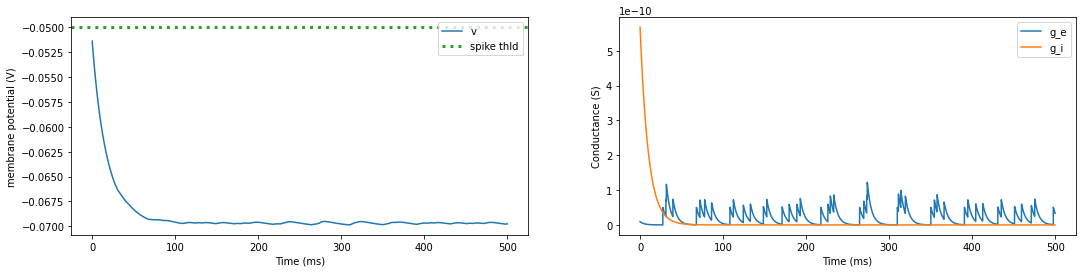

In [12]:
# SST Neurons plot

figure(figsize=(18, 4))
subplot(1, 2, 1)
plot(state_mon_sst.t / ms, state_mon_sst.v[0], label='v')
for (t, i) in zip(spike_mon_sst.t, spike_mon_sst.i):
    if i == 0:
        axvline(t / ms, ls='--', c='C1', lw=1)
axhline(V_t / mV / 1000, ls=':', c='C2', lw=3, label='spike thld')
xlabel('Time (ms)')
ylabel('membrane potential (V)')
legend(loc='upper right')

subplot(1, 2, 2)
plot(state_mon_sst.t / ms, state_mon_sst.g_e[0], label='g_e')
plot(state_mon_sst.t / ms, state_mon_sst.g_i[0], label='g_i')

xlabel('Time (ms)')
ylabel('Conductance (S)')
legend(loc='best')

print("Spike times SST: %s" % spike_mon_sst.t[:])

Spike times PV: [] s


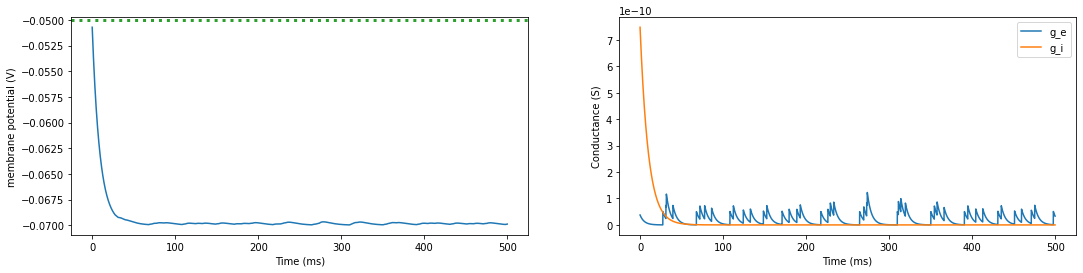

In [13]:
# PV Neurons plot

figure(figsize=(18, 4))
subplot(1, 2, 1)
plot(state_mon_pv.t / ms, state_mon_pv.v[0], label='v')
for (t, i) in zip(spike_mon_pv.t, spike_mon_pv.i):
    if i == 0:
        axvline(t / ms, ls='--', c='C1', lw=1)
axhline(V_t / mV / 1000, ls=':', c='C2', lw=3)
xlabel('Time (ms)')
ylabel('membrane potential (V)')

subplot(1, 2, 2)
plot(state_mon_pv.t / ms, state_mon_pv.g_e[0], label='g_e')
plot(state_mon_pv.t / ms, state_mon_pv.g_i[0], label='g_i')

xlabel('Time (ms)')
ylabel('Conductance (S)')
legend(loc='best')

print("Spike times PV: %s" % spike_mon_pv.t[:])

In [14]:
def count_spikes_for_neuron_type(spike_mon):
    a = pd.Series([i for i in spike_mon.i], dtype=int)
    return a.value_counts()


@check_units(sim_duration=ms)
def compute_firing_rate_for_neuron_type(spike_mon, sim_duration):
    spikes_for_i = count_spikes_for_neuron_type(spike_mon)
    return (spikes_for_i / sim_duration)*Hz


def compute_input_selectivity(inputs):
    return np.abs(inputs[0] - inputs[1])/(inputs[0] + inputs[1])


@check_units(sim_duration=ms, result=1)
def compute_output_selectivity_for_neuron_type(spike_mon, sim_duration):
    rates_for_i = compute_firing_rate_for_neuron_type(spike_mon, sim_duration)
    return np.abs(rates_for_i[0] - rates_for_i[1])/(rates_for_i[0] + rates_for_i[1])


def compute_interspike_intervals(spike_mon):
    by_neuron = []
    
    for neuron_index in spike_mon.spike_trains():
        interspike_intervals = np.diff(spike_mon.spike_trains()[neuron_index])
        by_neuron.append(interspike_intervals)
        
    return by_neuron

In [15]:
# Compute firing rate for each neuron group
firing_rates_cs = compute_firing_rate_for_neuron_type(spike_mon_cs, duration)
firing_rates_cc = compute_firing_rate_for_neuron_type(spike_mon_cc, duration)
firing_rates_sst = compute_firing_rate_for_neuron_type(spike_mon_sst, duration)
firing_rates_pv = compute_firing_rate_for_neuron_type(spike_mon_pv, duration)

print(f'Avg firing rate for CS neurons: {np.mean(firing_rates_cs) * Hz}')
print(f'Avg firing rate for CC neurons: {np.mean(firing_rates_cc) * Hz}')
print(f'Avg firing rate for SST neurons: {np.mean(firing_rates_sst) * Hz}')
print(f'Avg firing rate for PV neurons: {np.mean(firing_rates_pv) * Hz}')

Avg firing rate for CS neurons: 22. Hz
Avg firing rate for CC neurons: 23. Hz
Avg firing rate for SST neurons: nan Hz
Avg firing rate for PV neurons: nan Hz


In [16]:
# Compute input & output selectivity for CC & CS neuron groups
input_selectivity = compute_input_selectivity(I_ext_cs)
print(f'Input selectivity: {input_selectivity}')

output_selectivity_cs = compute_output_selectivity_for_neuron_type(spike_mon_cs, duration)
output_selectivity_cc = compute_output_selectivity_for_neuron_type(spike_mon_cc, duration)

print(f'Output selectivity CS: {output_selectivity_cs}')
print(f'Output selectivity CC: {output_selectivity_cc}')

Input selectivity: 0.02439024390243904
Output selectivity CS: 0.09090909090909091
Output selectivity CC: 0.043478260869565216


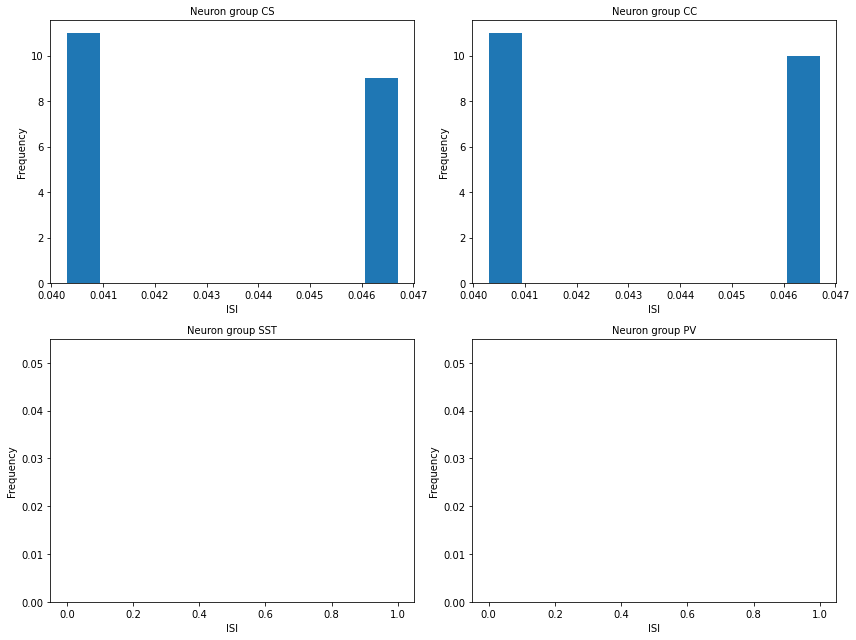

In [17]:
# Plot histogram of interspike intervals

interspike_intervals_cs = np.concatenate(compute_interspike_intervals(spike_mon_cs), axis=0)
interspike_intervals_cc = np.concatenate(compute_interspike_intervals(spike_mon_cc), axis=0)
interspike_intervals_sst = np.concatenate(compute_interspike_intervals(spike_mon_sst), axis=0)
interspike_intervals_pv = np.concatenate(compute_interspike_intervals(spike_mon_pv), axis=0)

index_to_ntype_dict = {
    0: 'CS',
    1: 'CC',
    2: 'SST',
    3: 'PV'
}
interspike_intervals = [interspike_intervals_cs, interspike_intervals_cc, interspike_intervals_sst, interspike_intervals_pv]

columns = 2
rows = int(len(interspike_intervals) / columns)

fig, axs = plt.subplots(rows, columns, figsize = (12, 9))

for (ntype_index, interspike_intervals_i) in enumerate(interspike_intervals):
    row_idx = int(ntype_index / columns)
    col_idx = ntype_index % columns
               
    axs[row_idx][col_idx].hist(interspike_intervals_i)
    axs[row_idx][col_idx].axis(ymin=0)
    axs[row_idx][col_idx].set_title(f'Neuron group {index_to_ntype_dict[ntype_index]}', fontsize = 10)
    axs[row_idx][col_idx].set_ylabel("Frequency", fontsize = 10)
    axs[row_idx][col_idx].set_xlabel("ISI", fontsize = 10)
    axs[row_idx][col_idx].tick_params(axis='both', which='major', labelsize=10)

    
plt.tight_layout()
plt.show()

(array([-19, -18, -17, -16, -15, -14, -13, -12, -11, -10,  -9,  -8,  -7,
        -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,   3,   4,   5,   6,
         7,   8,   9,  10,  11,  12,  13,  14,  15,  16,  17,  18,  19]), array([0.05009555, 0.1002986 , 0.15050165, 0.20082901, 0.25115664,
       0.30137676, 0.35147258, 0.40156813, 0.45177092, 0.49520113,
       0.53864814, 0.58992727, 0.6410821 , 0.69223639, 0.74349791,
       0.79490028, 0.84628638, 0.89756551, 0.94884491, 1.        ,
       0.94884491, 0.89756551, 0.84628638, 0.79490028, 0.74349791,
       0.69223639, 0.6410821 , 0.58992727, 0.53864814, 0.49520113,
       0.45177092, 0.40156813, 0.35147258, 0.30137676, 0.25115664,
       0.20082901, 0.15050165, 0.1002986 , 0.05009555]), <matplotlib.collections.LineCollection object at 0x155cd2b20>, <matplotlib.lines.Line2D object at 0x155cd2a30>)


Text(0.5, 1.0, 'Excitatory CS Neuron 0, Binsize = 0.0005s')

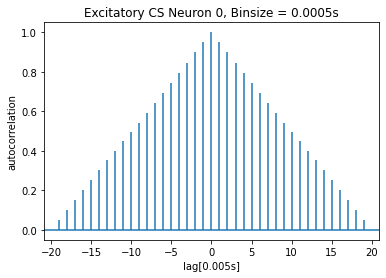

In [19]:
# Test autocorrelation
def autocorr(x, t=1):
    return np.corrcoef(np.array([x[:-t], x[t:]]))

ISI_cs = np.array(interspike_intervals_cs)
autocorr(ISI_cs)

print(plt.acorr(ISI_cs, normed = True, maxlags=None))
plt.xlabel("lag[0.005s]")
plt.ylabel("autocorrelation")
plt.title("Excitatory CS Neuron 0, Binsize = 0.0005s")